<a href="https://colab.research.google.com/github/Amin-asadii/DeepLearning/blob/main/RunModelDTCTCAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
print (torch.__version__)
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import Tensor
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_ur
from typing import Type, Any, Callable, Union, List, Optional
from torchvision import transforms

import torch.nn as nn
import torchvision.models as models
import copy
import torch.utils.data.dataloader
import torch.utils.data.dataset
import torch.utils.data
from torchvision.transforms import functional as F
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

1.8.1+cu101


In [ ]:
root ='/content/drive/MyDrive/data'
phase = 'test'

imgs = os.listdir(os.path.join(root, 'training_images'))
#targets = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
targets = pd.read_csv(os.path.join(root, '{}_solution_bounding_boxes (1).csv'.format(phase)))
idx=1000
img_path = os.path.join(root, 'training_images', imgs[idx] )
img = Image.open(img_path).convert('RGB')
#display
box_list = targets[targets['filename'] == imgs[idx]]
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values.dtype)
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values)


#display
box_list = targets[targets['filename'] == imgs[idx]]
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values.dtype)
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values)



float64
[]
float64
[]


In [ ]:
class cardataset (torch.utils.data.Dataset):
    def __init__(self, root, phase):
        self.root = root
        self.phase = phase

        #self.imgs = os.listdir(os.path.join(root, 'training_images'))
        #self.targets = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
       
        self.targets = pd.read_csv(os.path.join(root, '{}_solution_bounding_boxes (1).csv'.format(phase)))
        self.imgs = self.targets['filename']

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, 'training_images', self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        img = F.to_tensor(img)
        #tasvir target
        box_list = self.targets[self.targets['filename'] == self.imgs[idx]]
        box_list = box_list[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.tensor(box_list,  dtype=torch.float32)
        #
        labels = torch.ones((len(box_list), ), dtype=torch.int64)
        #
        target = {}
        target['boxes'] = boxes
        target ['labels'] = labels

        return img, target
    def __len__(self):
        return len(self.imgs)

In [ ]:
test_dataset = cardataset('/content/drive/MyDrive/data', 'test')
#print (train_dataset.__getitem__(1000))
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1 , shuffle=True, collate_fn=new_concat)
#print (train_loader)
#print (next(iter(train_loader)))
#print (targets)
#imgs , targets = next (iter(train_loader))
print(test_loader)

In [ ]:

    # Model CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024 , 2)
#model.classifier[1] = nn.Linear(1280, 21)
model.load_state_dict(copy.deepcopy(torch.load("/content/drive/MyDrive/data/model_state_DETECT.pth",device)))

model.to(device)

    # loss
loss_fn = nn.CrossEntropyLoss()
#



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
!mkdir /content/output_images

In [ ]:
!mkdir /content/output_images/1

In [ ]:
import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow


def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #cv2_imshow(img.imag)
            
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none')
                print(len(bxs))
                
                ax.add_patch(rect)
                
                crop_img = img[int(bxs[i][1]):int(bxs[i][1]) + abs (int(bxs[i][1]) - int(bxs[i][3])), int(bxs[i][0]):int(bxs[i][0])+ abs (int (bxs[i][0] - bxs[i][2]))]
                
                ax.imshow(crop_img)
                #ax.imshow(img)
                cv2.imwrite("iamge_"+str(i)+".jpg", crop_img)
                #print(crop_img)
                
                
                #cv2.imshow("crop", crop_img)
            fig.savefig("/content/output_images/1/{}.png".format(cnt), dpi=99, bbox_inches='tight')
            cnt = cnt + 1

1
1
1
1
1
1


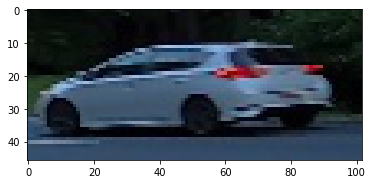

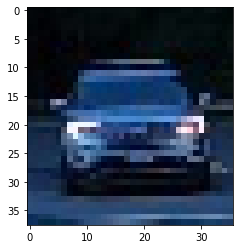

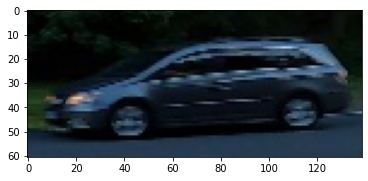

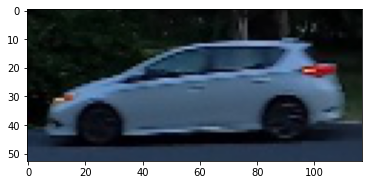

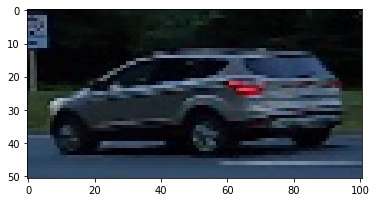

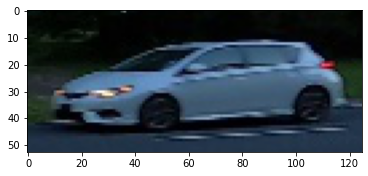

In [ ]:
evaluate(model, test_loader)

In [ ]:

batch_size = 1
num_classes = 10
lr = 0.001
num_epochs = 50
feature_extract = True
img_dir = '/content/output_images'

testset = torchvision.datasets.ImageFolder(os.path.join(img_dir),
                                                transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                             ]))

testloader  = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=False)
classes = ('Acura Integra Type R 2001', 'Aston Martin V8 Vantage Convertible 2012', 
           
           'Audi 100 Sedan 1994', 'Bentley Arnage Sedan 2009', 'BMW 1 Series Convertible 2012',
           'Bugatti Veyron 16.4 Convertible 2009', 'Buick Enclave SUV 2012', 'Cadillac CTS-V Sedan 2012',
           'Chevrolet Avalanche Crew Cab 2012', 'Chrysler 300 SRT-8 2010',
           'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2007', 'Eagle Talon Hatchback 1998',
           'Ferrari 458 Italia Convertible 2012', 'FIAT 500 Abarth 2012',
           'Fisker Karma Sedan 2012', 'Ford Edge SUV 2012', 'Geo Metro Convertible 1993', 'GMC Acadia SUV 2012', 'HUMMER H2 SUT Crew Cab 2009',
           'Honda Accord Coupe 2012')
classesListModel = ['Acura Integra Type R 2001', 'Aston Martin V8 Vantage Convertible 2012', 
           
           'Audi 100 Sedan 1994', 'Bentley Arnage Sedan 2009', 'BMW 1 Series Convertible 2012',
           'Bugatti Veyron 16.4 Convertible 2009', 'Buick Enclave SUV 2012', 'Cadillac CTS-V Sedan 2012',
           'Chevrolet Avalanche Crew Cab 2012', 'Chrysler 300 SRT-8 2010',
           'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2007', 'Eagle Talon Hatchback 1998',
           'Ferrari 458 Italia Convertible 2012', 'FIAT 500 Abarth 2012',
           'Fisker Karma Sedan 2012', 'Ford Edge SUV 2012', 'Geo Metro Convertible 1993', 'GMC Acadia SUV 2012', 'HUMMER H2 SUT Crew Cab 2009',
           'Honda Accord Coupe 2012']



Audi 100 Sedan 1994
Audi 100 Sedan 1994
Dodge Caliber Wagon 2007
Audi 100 Sedan 1994
Audi 100 Sedan 1994
Aston Martin V8 Vantage Convertible 2012
Audi 100 Sedan 1994
Audi 100 Sedan 1994
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Convertible 2012
Dodge Caliber Wagon 2007
Audi 100 Sedan 1994
Dodge Caliber Wagon 2007
Aston Martin V8 Vantage Convertible 2012
Dodge Caliber Wagon 2007
Chevrolet Avalanche Crew Cab 2012
Aston Martin V8 Vantage Convertible 2012
Chevrolet Avalanche Crew Cab 2012
Bentley Arnage Sedan 2009
Audi 100 Sedan 1994
Aston Martin V8 Vantage Convertible 2012
Audi 100 Sedan 1994
Audi 100 Sedan 1994
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Convertible 2012
Dodge Caliber Wagon 2007
Chevrolet Avalanche Crew Cab 2012
Aston Martin V8 Vantage Convertible 2012
Chevrolet Avalanche Crew Cab 2012
Chevrolet Avalanche Crew Cab 2012


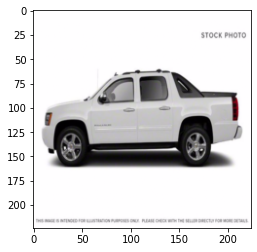

In [ ]:
    # Model CNN
import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow
ax,fige = plt.subplots()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
convmodel = torchvision.models.mobilenet_v2()
convmodel.classifier[1] = nn.Linear(1280, 21)
convmodel.load_state_dict(copy.deepcopy(torch.load("/content/drive/MyDrive/data/model_state_MODELCAR.pth",device)))

convmodel.to(device)

    # loss
loss_fn = nn.CrossEntropyLoss()
#


    convmodel.eval()
    corrects = 0
    cnt = 0
    num_steps = len(testloader)
    for j, (imgs, lbls) in enumerate(testloader):
        
        
        
        #corrects = 00
    
        imgs = imgs.to(device)
        
        lbls = lbls.to(device)
        out = convmodel(imgs)
        predicted = torch.argmax(out, 1)
        print(classesListModel[predicted])
        imag = imgs[0].permute(1, 2, 0).cpu().numpy()
        
        
        
        fige.imshow(imag)
        
        
        
        corrects += torch.sum(predicted == lbls)
        fige.figure.savefig("/content/output_images/1/{}.png".format(cnt), dpi=99, bbox_inches='tight')
        
        cnt = cnt + 1
        #print('Step [{}/{}] Acc {:.4f}: '.format(j+1, num_steps, 100.*corrects/((j+1)*batch_size)))



In [ ]:
from google.colab.patches import cv2_imshow

TypeError: ignored

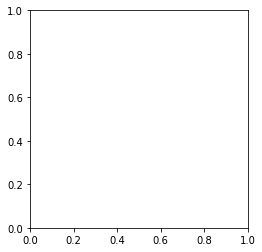

In [ ]:
import numpy as np

import cv2

from matplotlib import pyplot as plt

img = cv2.imread('/content/output_images/1/hondared.jpeg',1)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')


img1 = cv2.imread('/content/output_images/1/0.png',1)
plt.imshow(img1, cmap = 'gray', interpolation = 'bicubic')

plt.xticks([]), plt.yticks([])

# to hide tick values on X and Y axis

plt.show()



In [ ]:
classes = ('black','blue','brown', 'green', 'pink', 'red', 'silver', 'white', 'yellow' )
classesListColor = ['black','blue','brown', 'green', 'pink', 'red', 'silver', 'white', 'yellow' ]

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Colorconvmodel = torchvision.models.mobilenet_v2()
Colorconvmodel.classifier[1] = nn.Linear(1280, 9)
Colorconvmodel.load_state_dict(copy.deepcopy(torch.load("/content/drive/MyDrive/data/model_state_COLOR1 (1).pth",device)))

Colorconvmodel.to(device)

    # loss
loss_fn = nn.CrossEntropyLoss()
#



pink
pink
pink
pink
pink
pink
pink
white
pink
black
pink
pink
pink
pink
pink
pink
pink
pink
white
pink
pink
pink
pink
pink
pink
red
white
silver
black
white


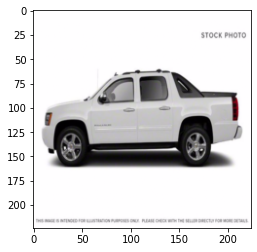

In [ ]:
    import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow
ax,fige = plt.subplots()

    Colorconvmodel.eval()
    corrects = 0
    num_steps = len(testloader)
    for j, (imgs, lbls) in enumerate(testloader):
        #corrects = 00
        
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        out = Colorconvmodel(imgs)
        predicted = torch.argmax(out, 1)
        #print(imgs.shape)
        #cv2.imshow('imgs',imgs)
        
        #print(predicted)
        print(classesListColor[predicted])
        fige.imshow(imag)
        
  
        corrects += torch.sum(predicted == lbls)
        #print('Step [{}/{}] Acc {:.4f}: '.format(j+1, num_steps, 100.*corrects/((j+1)*batch_size)))